## Data Exploration

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import plotly.express as px

sns.set_theme()

In [2]:
class Feats():
    """
    Each feature has a first name, optionally a second name, a statistic and a number.
    This class allows to group feautures according to these aspects or combinations of these aspects.
    Each method produces a list of feature names or a list of lists of feature names.
    """

    def __init__(self, csv):
        self.fts = pd.read_csv(csv, dtype={'n':"string"})
        self.fts = self.fts.fillna('')

    def format(self, select):
        return select.apply(lambda x: '_'.join(x).replace('__', '_'), axis=1).tolist()

    def all(self):
        select = self.fts.copy()
        return self.format(select)

    def first(self):
        select = self.fts.copy()
        select = select.loc[select['n']=='01']
        return self.format(select)

    def min(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='min']
        return self.format(select)
    
    def max(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='max']
        return self.format(select)

    def median(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='median']
        return self.format(select)

    def mean(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='mean']
        return self.format(select)
    
    def std(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='std']
        return self.format(select)

    def skew(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='skew']
        return self.format(select)

    def kurtosis(self):
        select = self.fts.copy()
        select = select.loc[select['stat']=='kurtosis']
        return self.format(select)

    def per_nns(self):
        """
        List of lists per name1, name2, stat, per name1, name2.
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['stat'], sort=False)] for idx, grp in select.groupby(by=['name1', 'name2'])]
        return select
    
    def per_sn(self):
        """
        List of lists per stat, n. 
        """
        select = self.fts.copy()
        select = [[self.format(grp2) for idx2, grp2 in grp.groupby(by=['n'], sort=False)] for idx, grp in select.groupby(by=['stat'], sort=False)]
        return select

fts = Feats('features.csv')

In [3]:
# Read data
df = pd.read_csv('data/red.csv', parse_dates=['release'])

### 1. Dimensionality reduction

#### Popularity

In [4]:
# PCA

bins = [0, 10, 100, 1000, 10000, 100000, 1000000]
labels = ["1s", "10s", "100s", "1000s", "10.000s", "100.000s"]

df['popularity_bins'] = pd.cut(df['popularity'], bins=bins, labels=labels, right=False)
df['popularity_bins'] = df['popularity_bins'].cat.add_categories('unknown').fillna('unknown')

pca = PCA(n_components=2)
components = pca.fit_transform(df[fts.all()])

fig = px.scatter(components, x=0, y=1, color=df['popularity_bins'])
fig.show()

#### Release

In [5]:
bins = [1900, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2022]
labels = ['<1960', "'60s", "'70s", "'80s", "'90s", "'00s", "'10s", ">2020"]

df['release_bins'] = pd.cut(df['release'].dt.year, bins=bins, labels=labels, right=False)
df['release_bins'] = df['release_bins'].cat.add_categories('unknown').fillna('unknown')

pca = PCA(n_components=2)
components = pca.fit_transform(X=df[fts.all()])

fig = px.scatter(components, x=0, y=1, color=df['release_bins'])
fig.show()

### 2. Statistics

#### Features

In [6]:
print(df[fts.first()].describe())

       chroma_cens_min_01  chroma_cens_max_01  chroma_cens_median_01  \
count        15000.000000        15000.000000           15000.000000   
mean             0.009331            0.622231               0.248148   
std              0.033029            0.084841               0.093837   
min              0.000000            0.059676               0.000000   
25%              0.000000            0.571604               0.200341   
50%              0.000000            0.640845               0.242851   
75%              0.000000            0.683921               0.295996   
max              0.602270            1.000000               0.783342   

       chroma_cens_mean_01  chroma_cens_std_01  chroma_cens_skew_01  \
count         15000.000000        15000.000000         15000.000000   
mean              0.256580            0.125444             0.253894   
std               0.080706            0.038299             1.017176   
min               0.000006            0.000493            -9.470790

#### Targets

In [7]:
# Targets
print("Popularity")
print(df.popularity.describe())
print('')
print("Release")
print(df.release.describe(datetime_is_numeric=True))

Popularity
count     15000.000000
mean       2361.360800
std        8390.463423
min           2.000000
25%         284.000000
50%         754.500000
75%        2005.250000
max      429168.000000
Name: popularity, dtype: float64

Release
count                             9820
mean     2011-03-25 14:24:35.193482752
min                1905-01-10 00:00:00
25%                2009-04-11 00:00:00
50%                2011-12-16 00:00:00
75%                2014-03-28 00:00:00
max                2021-03-01 00:00:00
Name: release, dtype: object


### 3. Distributions

#### Features

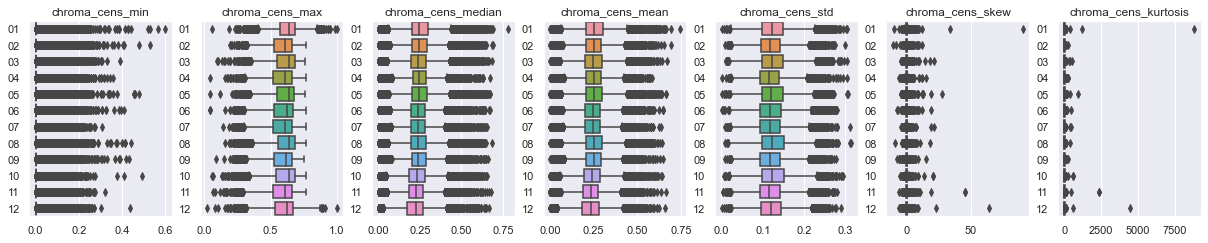

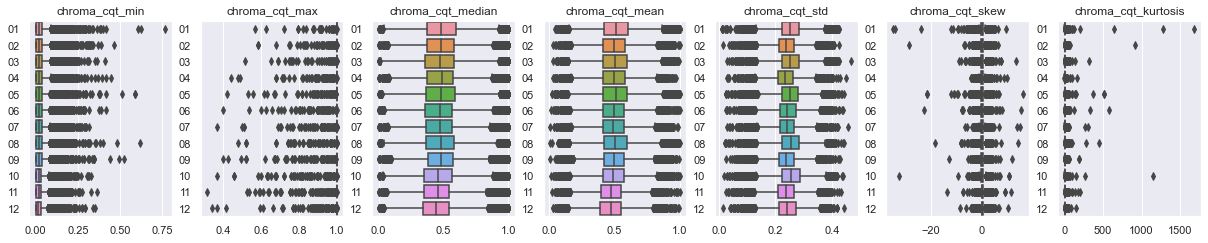

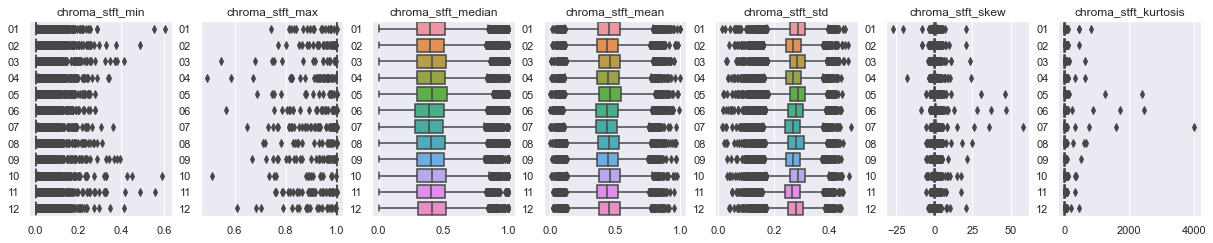

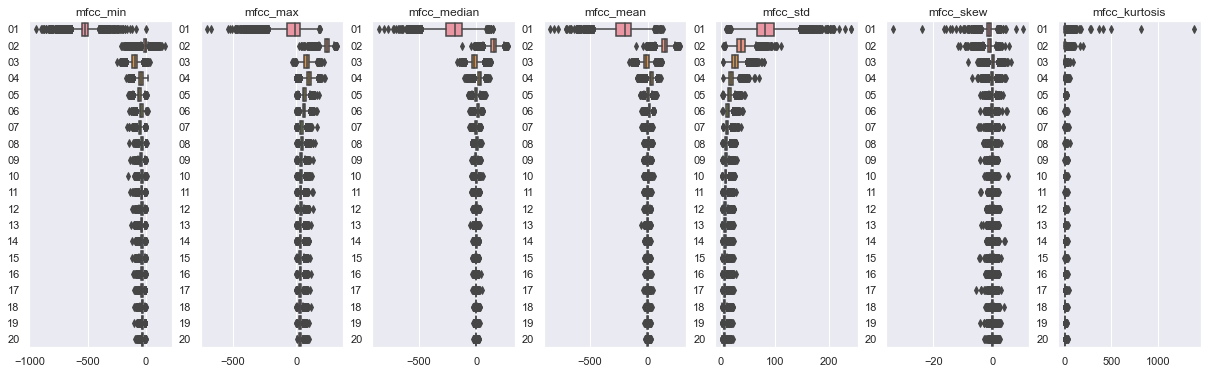

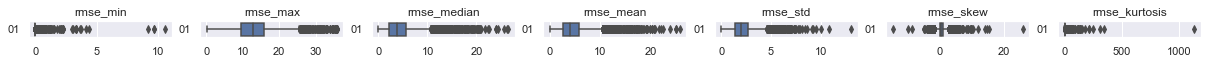

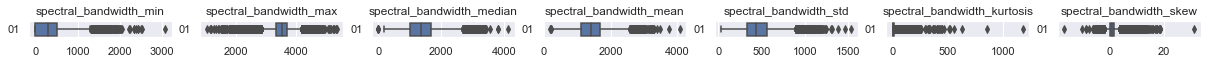

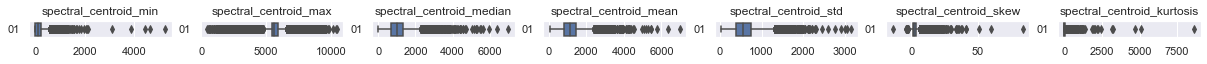

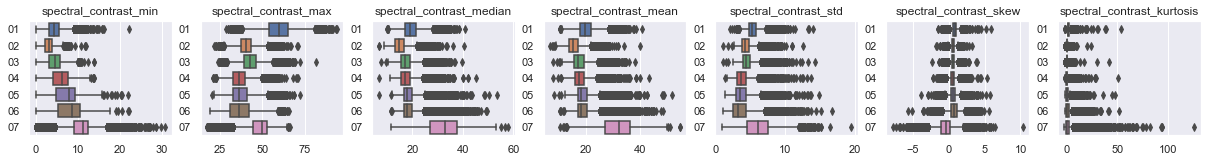

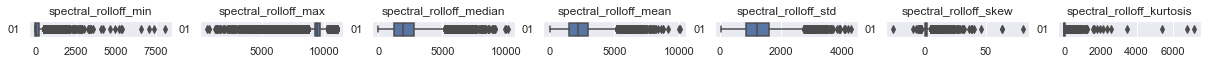

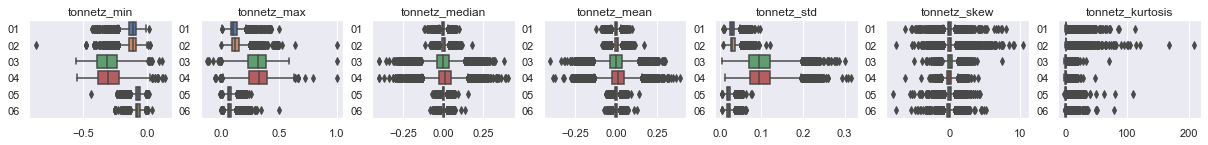

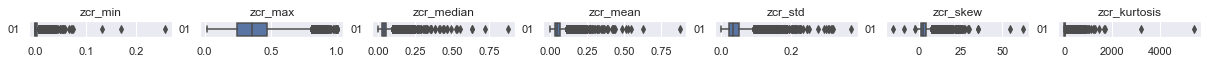

In [8]:
fts_groups = fts.per_nns()

for fnn_group in fts_groups:
    n = len(fnn_group[0])
    c, r = 7, 1
    fig, axs = plt.subplots(ncols=c, nrows=r, figsize=(3*c, 3*r*0.1*n))

    for i in range(c):
        fnns_group = fnn_group[i]
        ax = sns.boxplot(data=df[fnns_group], orient='h', ax=axs[i])

        title = "_".join(fnns_group[0].split("_")[:-1])
        ax.set(title=title)
        y_ticks = [n.split('_')[-1] for n in fnns_group]
        ax.set_yticklabels(y_ticks)
    
fig;

#### Targets

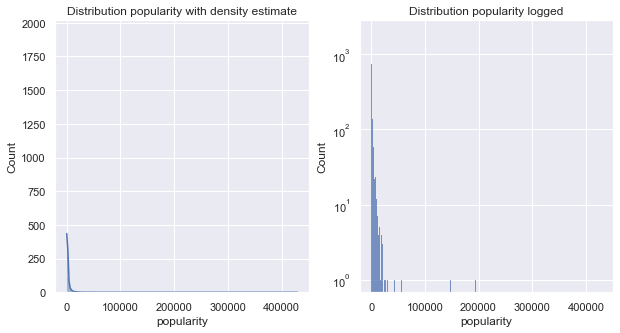

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(data=df, x="popularity", kde=True, ax=axs[0])
ax1.set(title="Distribution popularity with density estimate")

ax2 = sns.histplot(data=df, x="popularity", log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution popularity logged")

fig;

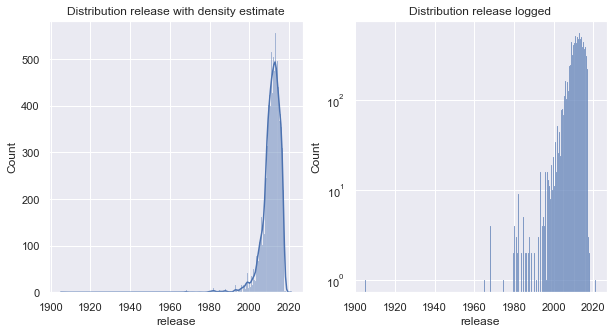

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax1 = sns.histplot(data=df, x="release", kde=True, ax=axs[0])
ax1.set(title="Distribution release with density estimate")

ax2 = sns.histplot(data=df, x="release", log_scale=(False, True), ax=axs[1])
ax2.set(title="Distribution release logged")

fig;

### 4. Covariance and correlation

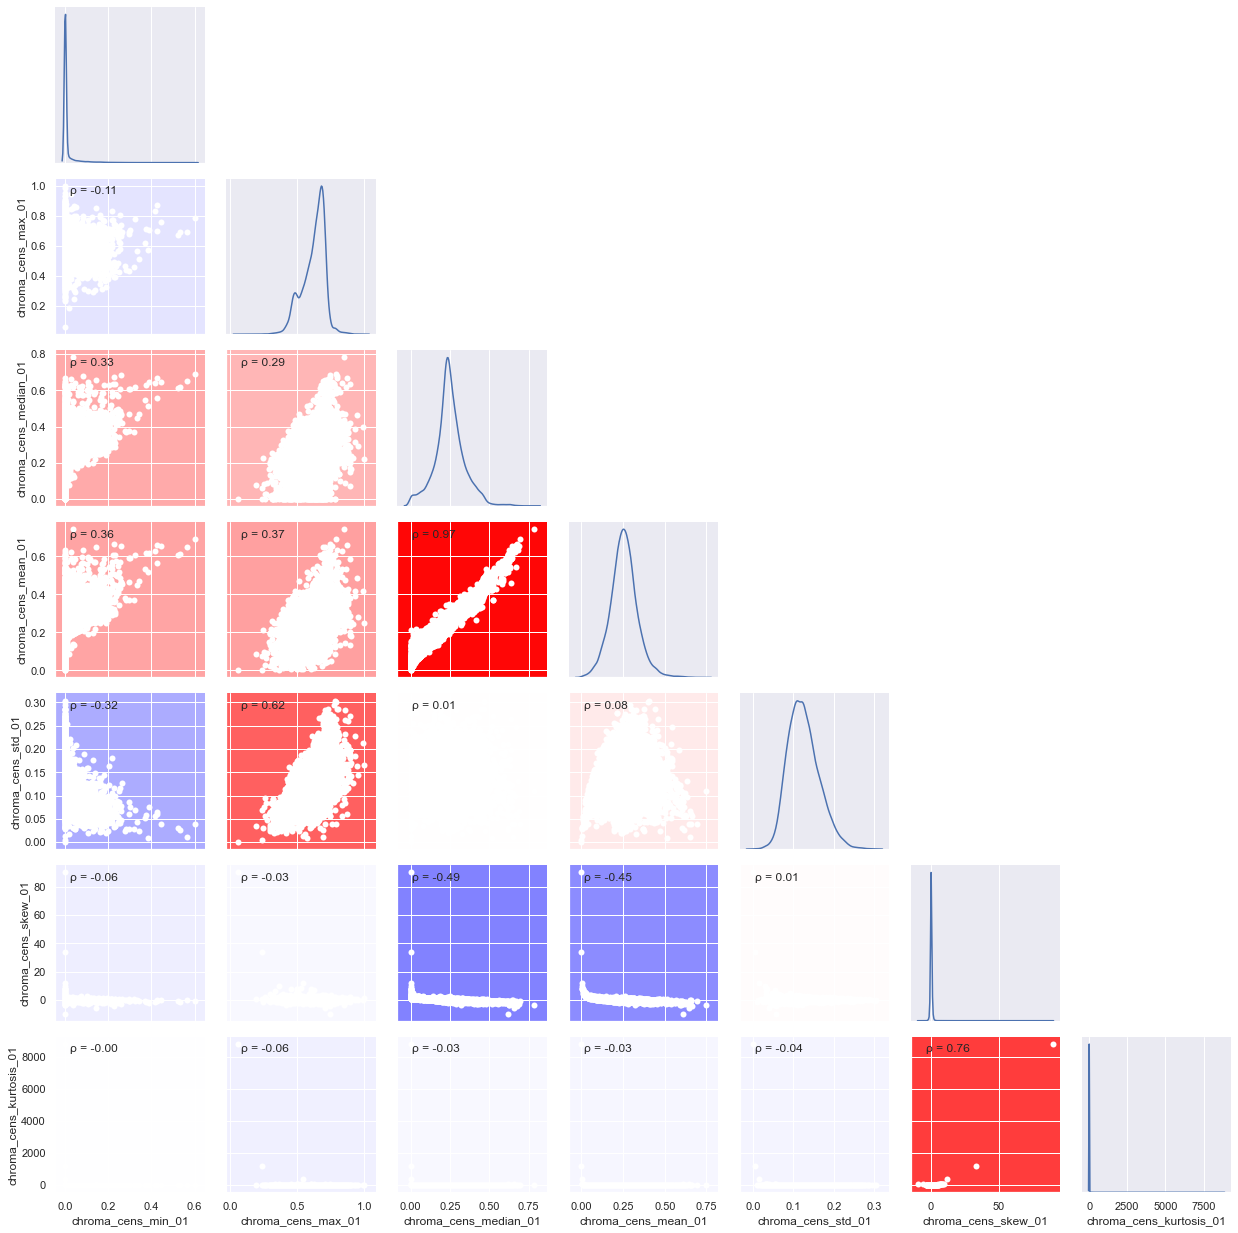

In [11]:
# per name_1, name_2, stat, first

cm = plt.cm.bwr
cnorm = colors.Normalize(vmin=-1, vmax=1)
smap = plt.cm.ScalarMappable(norm=cnorm, cmap=cm)

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.set_facecolor(smap.to_rgba(r))

fig = sns.PairGrid(df[fts.first()[:7]], diag_sharey=False, corner=True)
fig.map_diag(sns.kdeplot)
fig.map_lower(sns.scatterplot, color = 'w', linewidth = 0)
fig.map_lower(corrfunc)

fig;

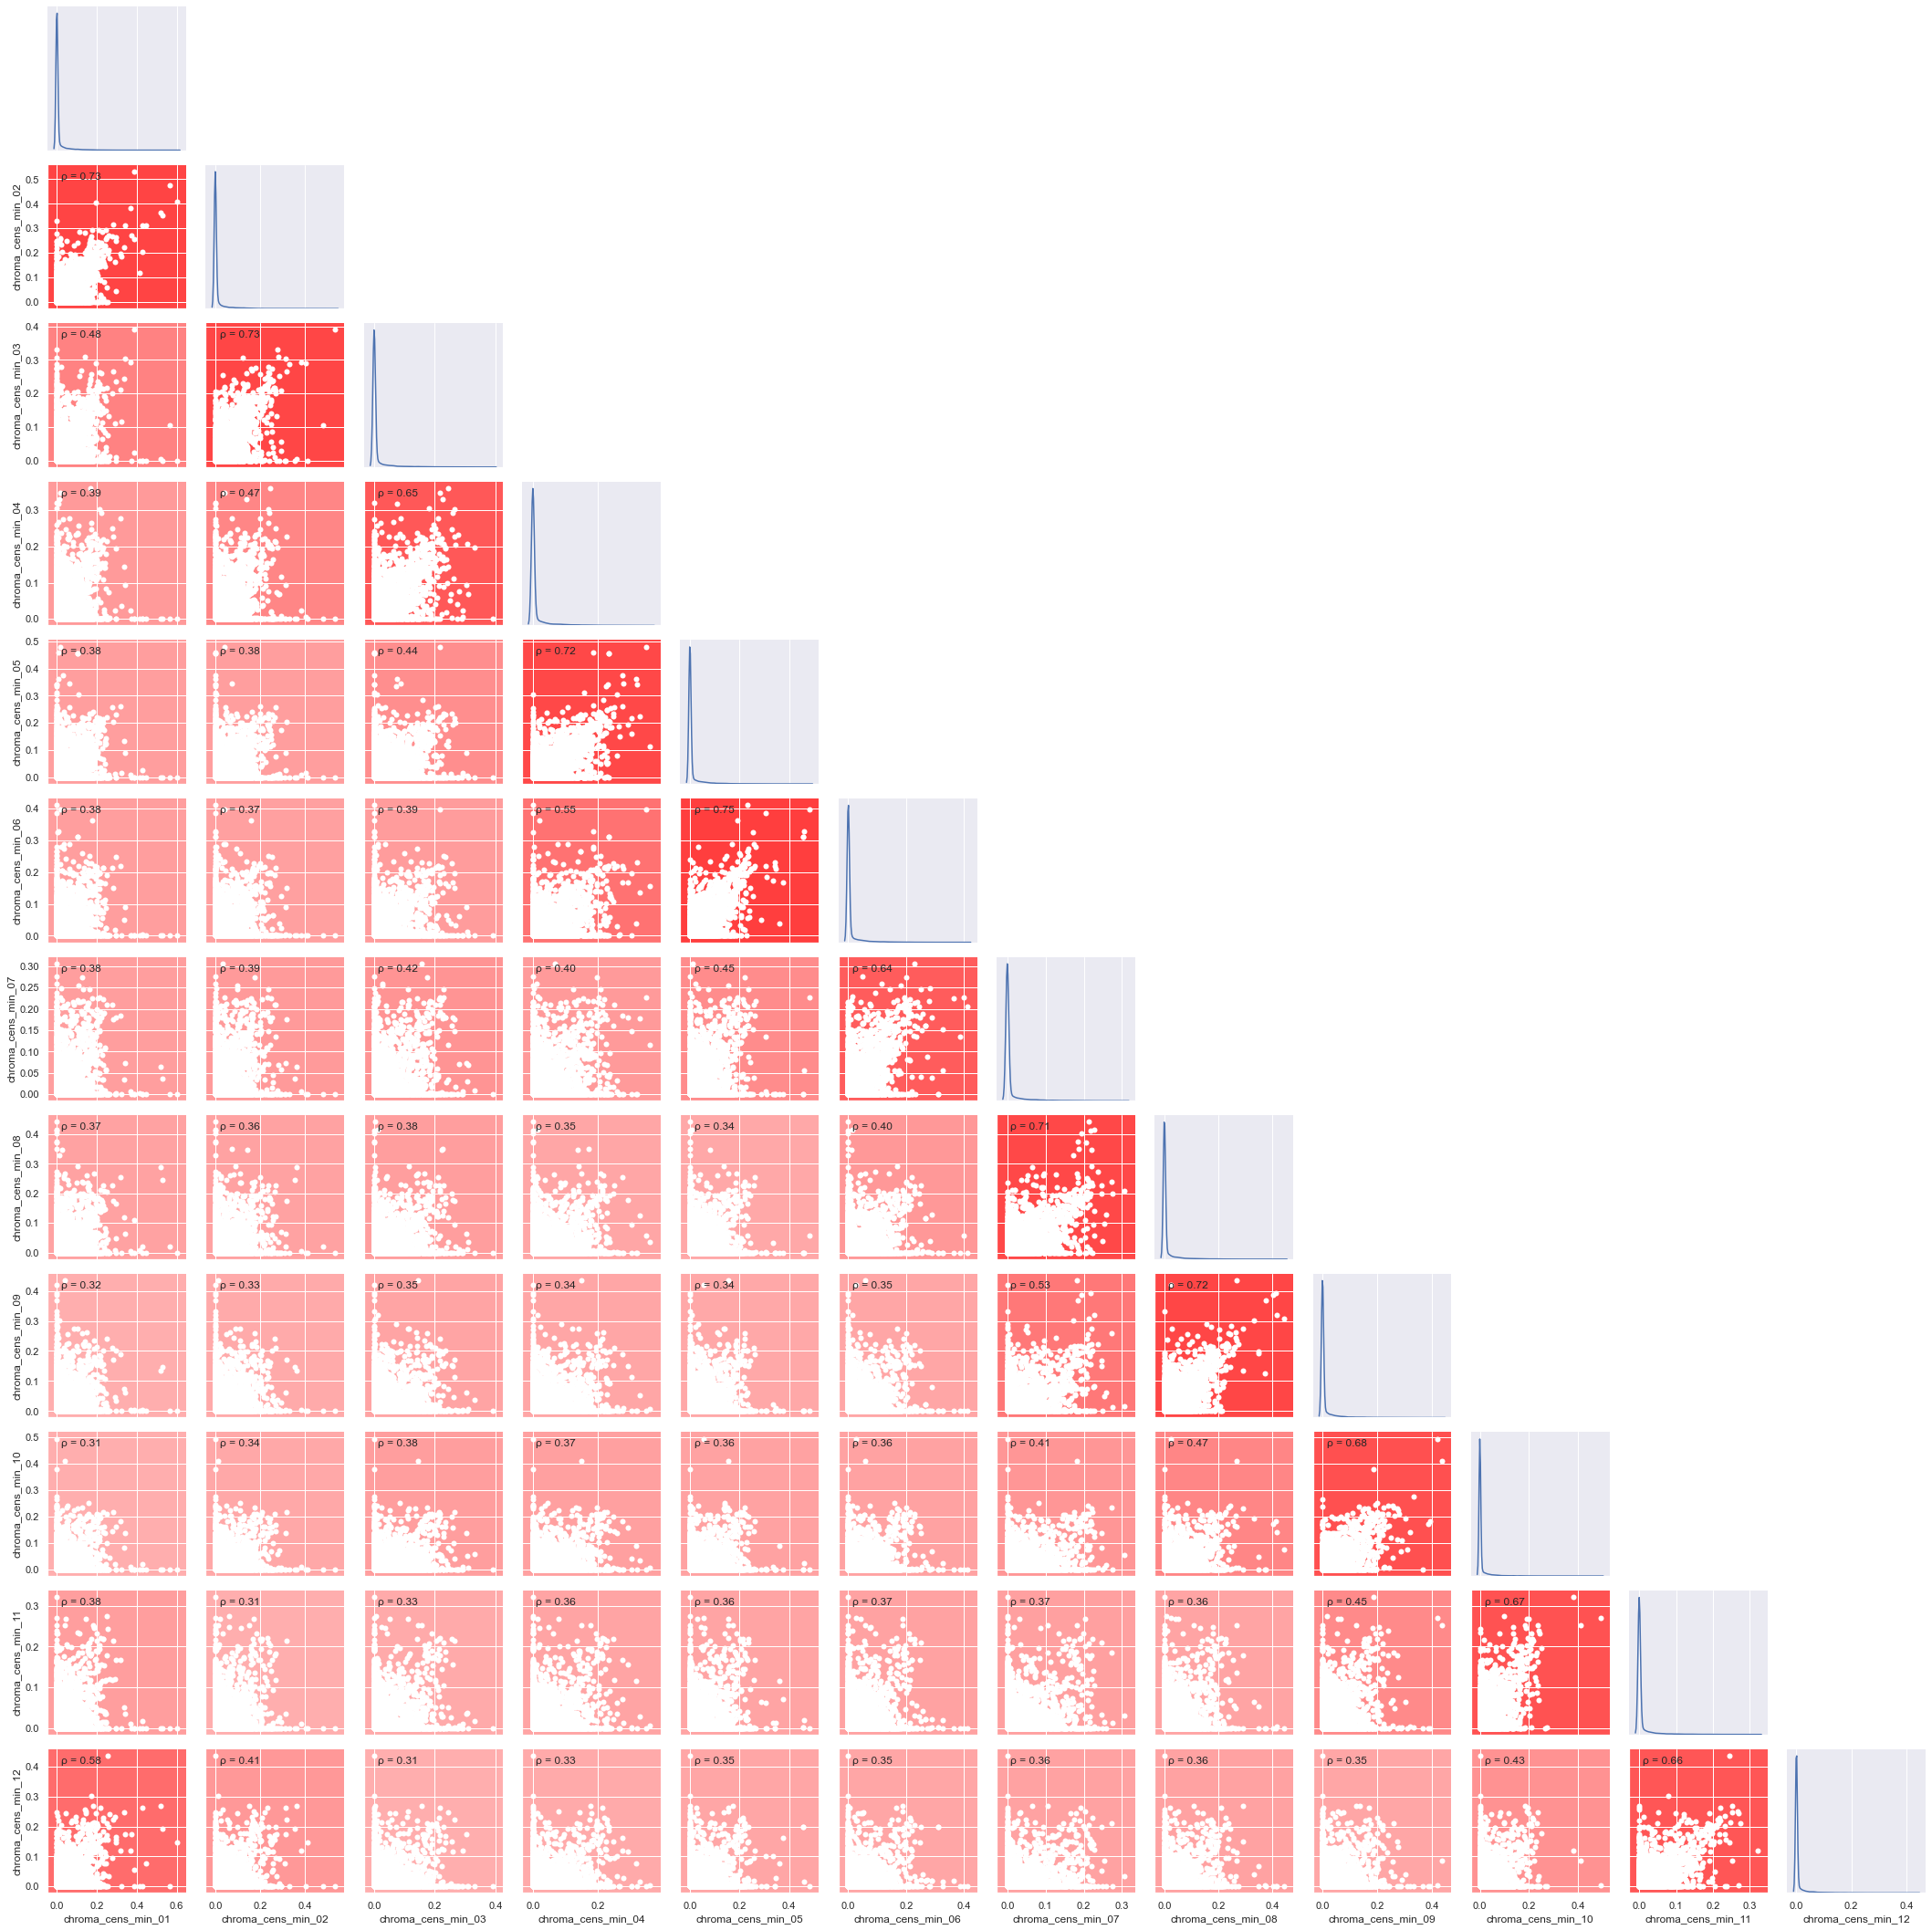

In [12]:
# per name_1, name_2, stat, n

cm = plt.cm.bwr
cnorm = colors.Normalize(vmin=-1, vmax=1)
smap = plt.cm.ScalarMappable(norm=cnorm, cmap=cm)

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.set_facecolor(smap.to_rgba(r))

fig = sns.PairGrid(df[fts.all()[0:12]], diag_sharey=False, corner=True)
fig.map_diag(sns.kdeplot)
fig.map_lower(sns.scatterplot, color = 'w', linewidth = 0)
fig.map_lower(corrfunc)

fig;

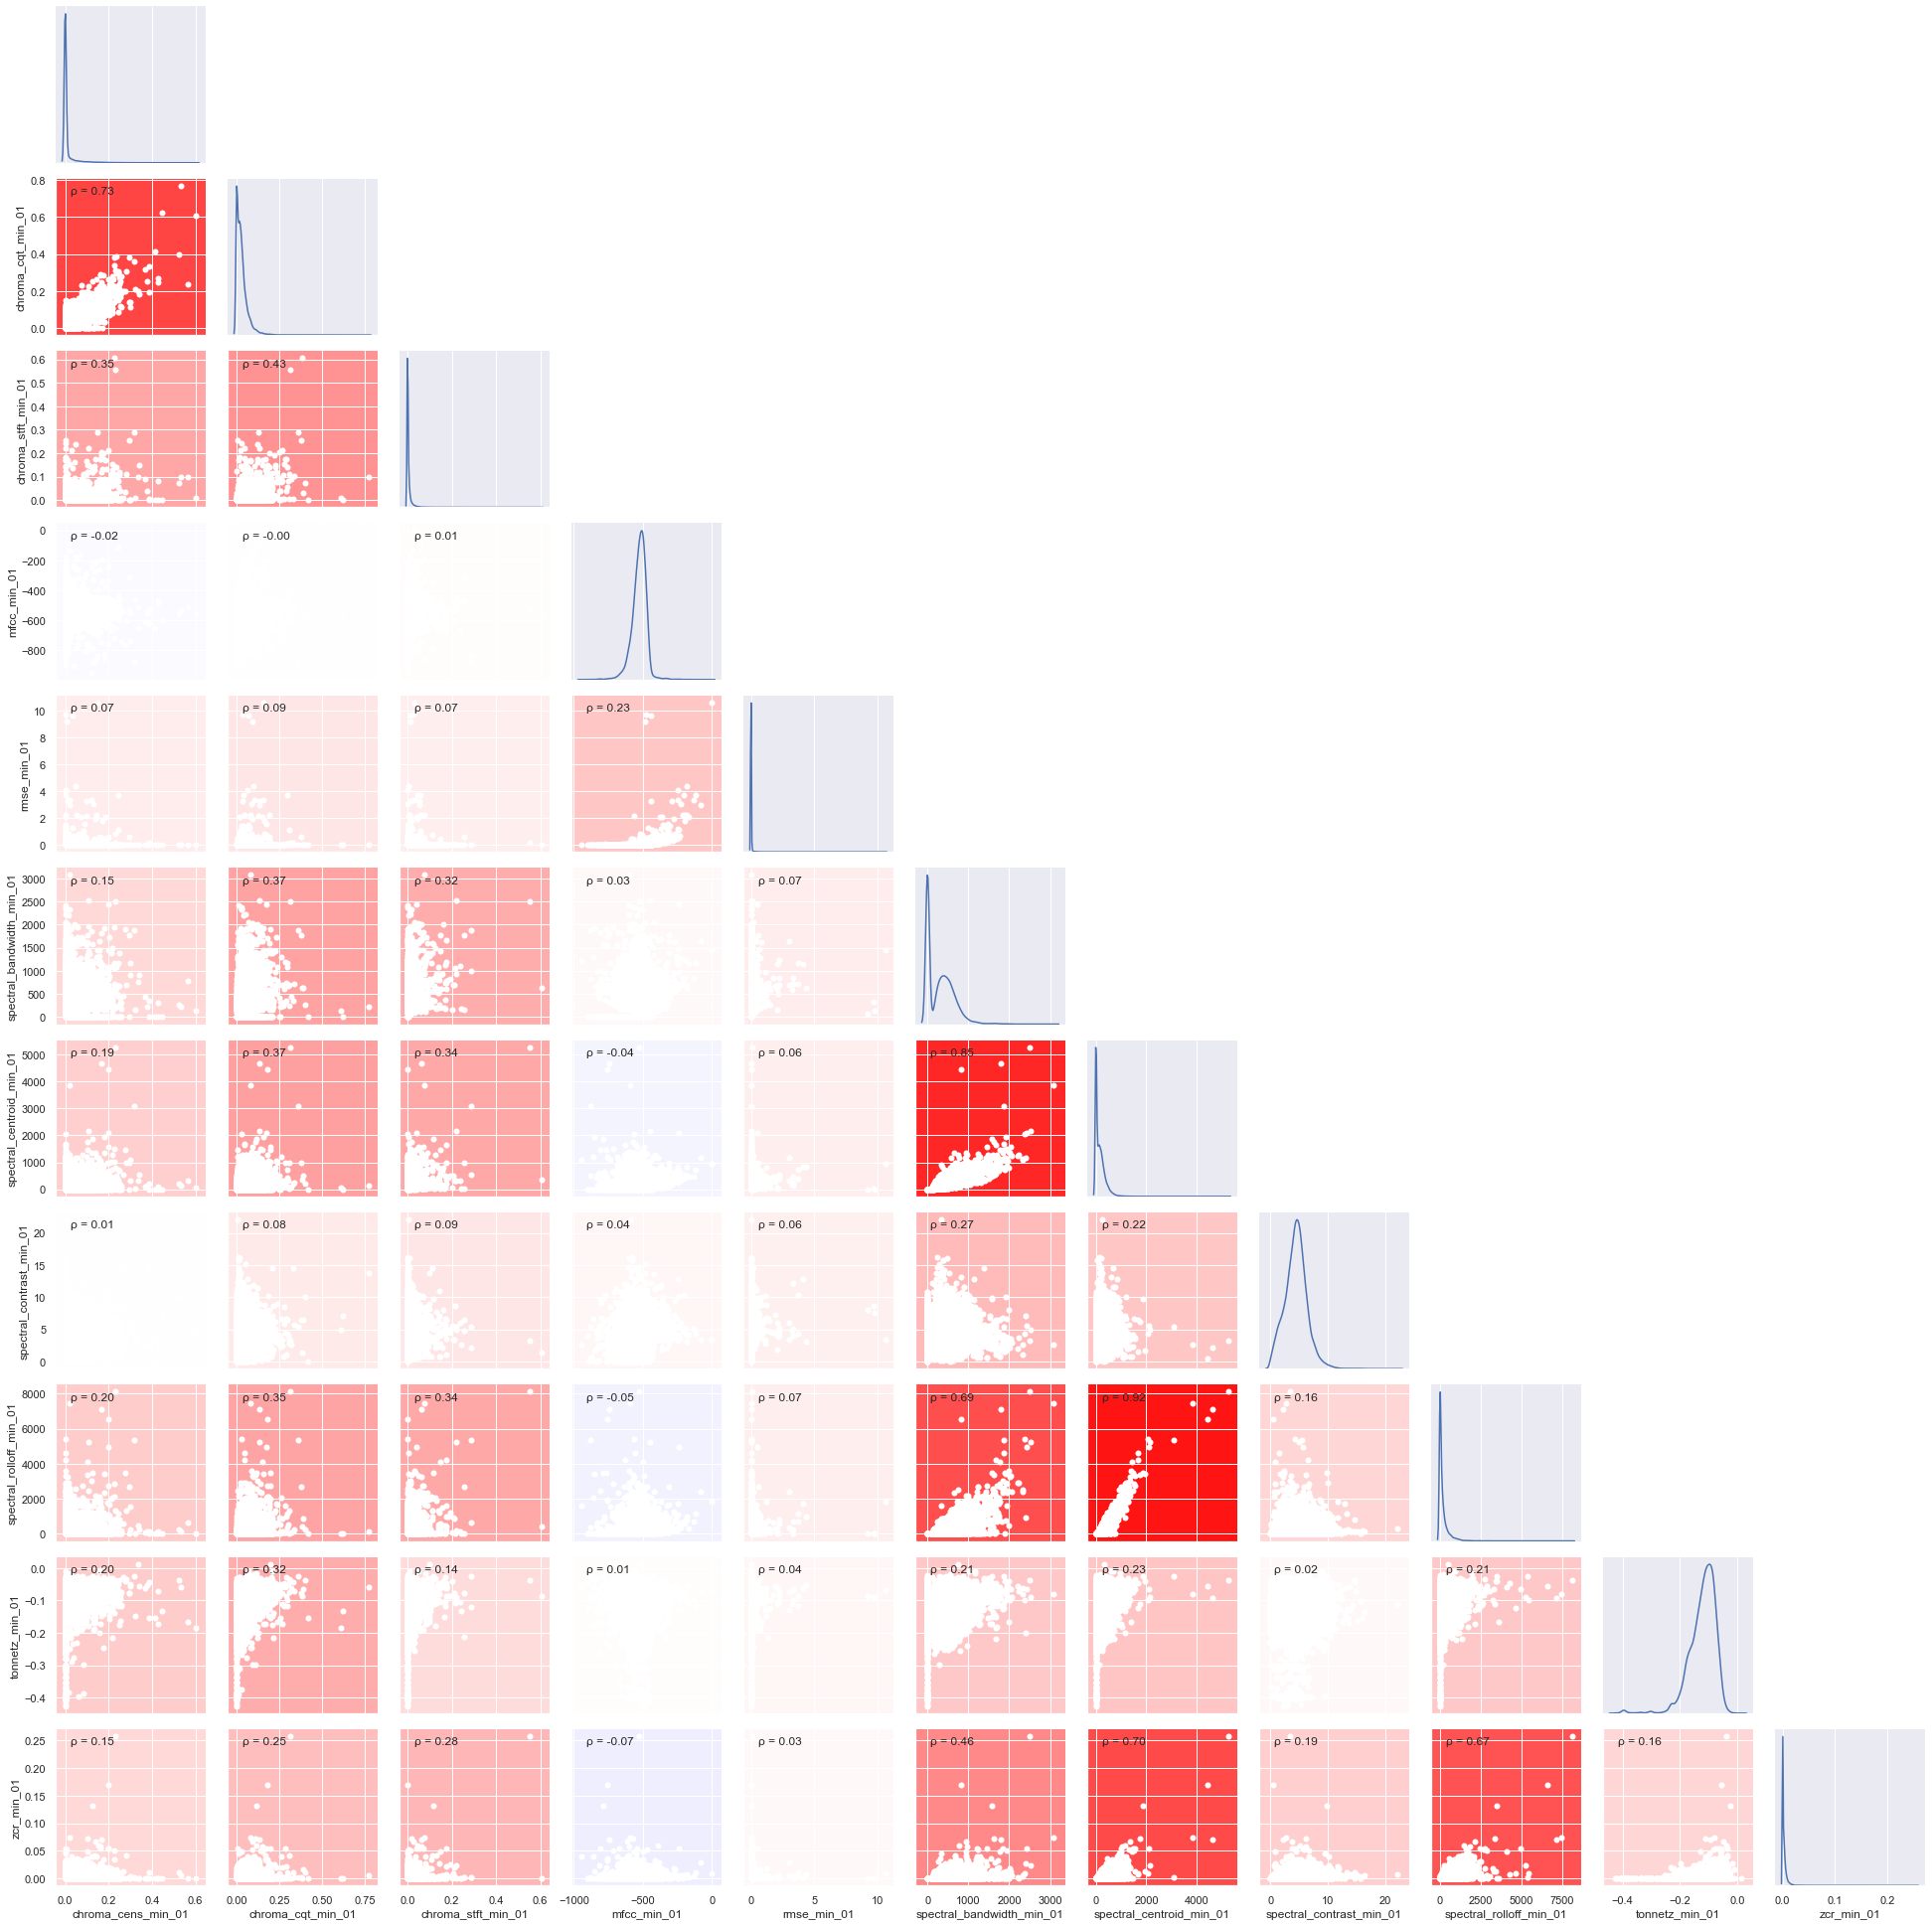

In [13]:
# stat, first

cm = plt.cm.bwr
cnorm = colors.Normalize(vmin=-1, vmax=1)
smap = plt.cm.ScalarMappable(norm=cnorm, cmap=cm)

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.set_facecolor(smap.to_rgba(r))

fig = sns.PairGrid(df[fts.per_sn()[0][0]], diag_sharey=False, corner=True)
fig.map_diag(sns.kdeplot)
fig.map_lower(sns.scatterplot, color = 'w', linewidth = 0)
fig.map_lower(corrfunc)

fig;

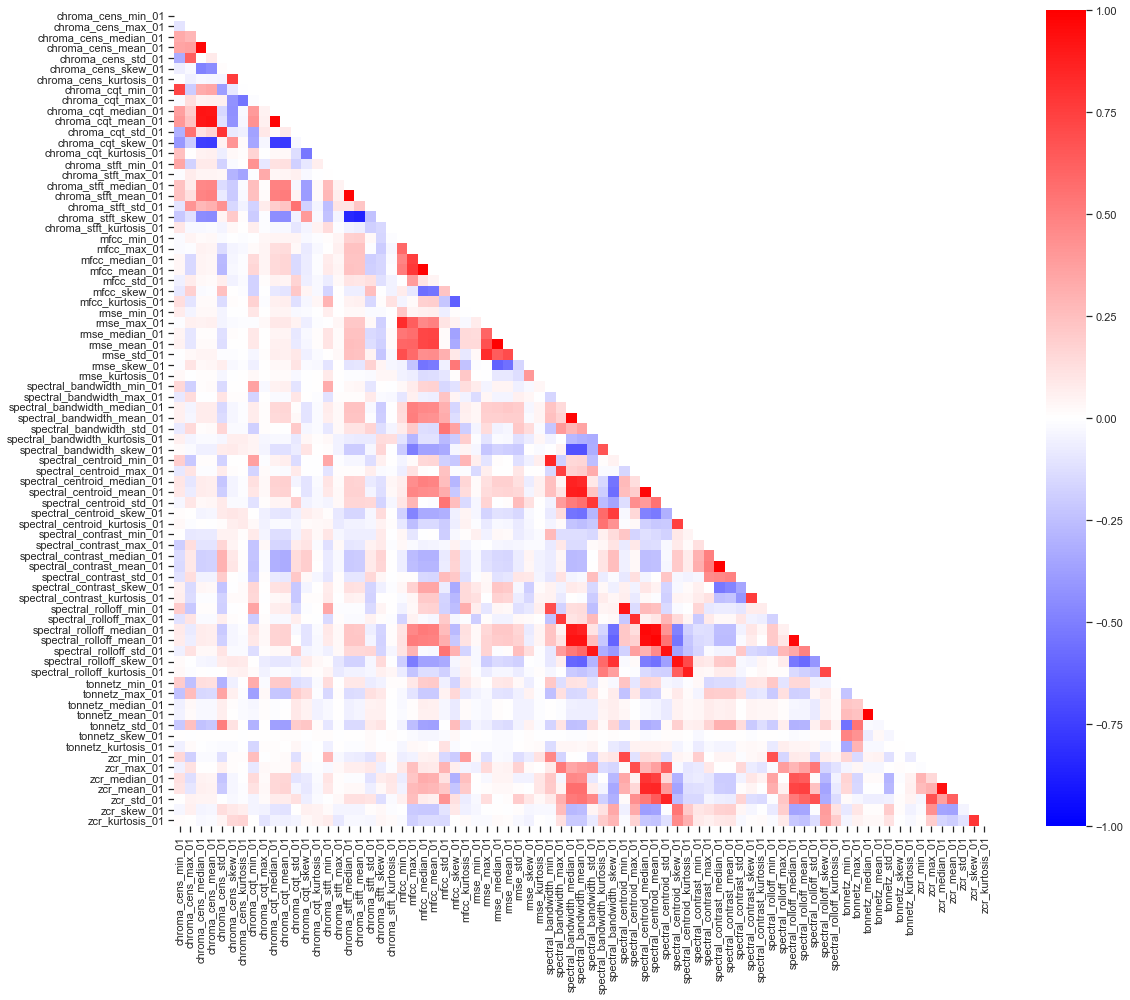

In [14]:
corr = df[fts.first()].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, square=True)
    ax.tick_params(left=True, bottom=True)

fig;

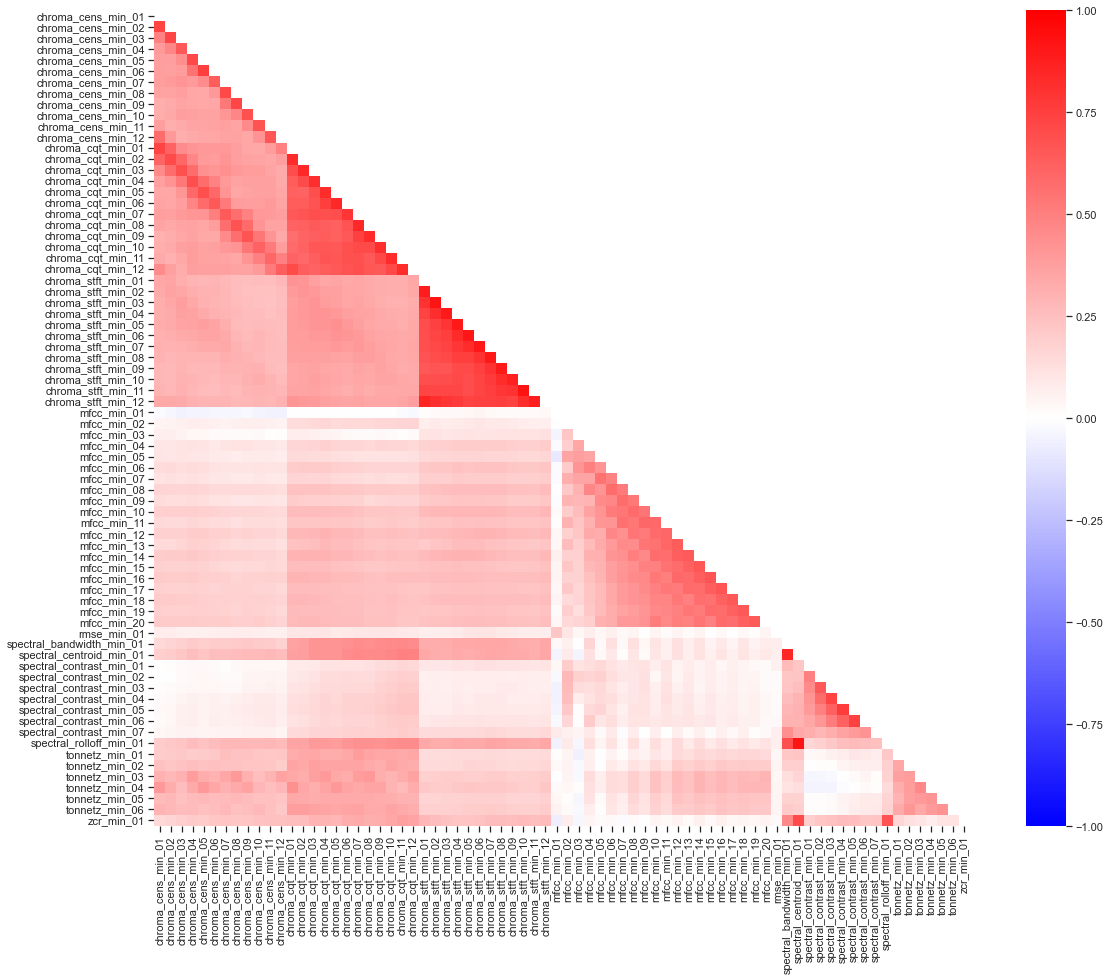

In [15]:
corr = df[fts.min()].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, square=True)
    ax.tick_params(left=True, bottom=True)

fig;

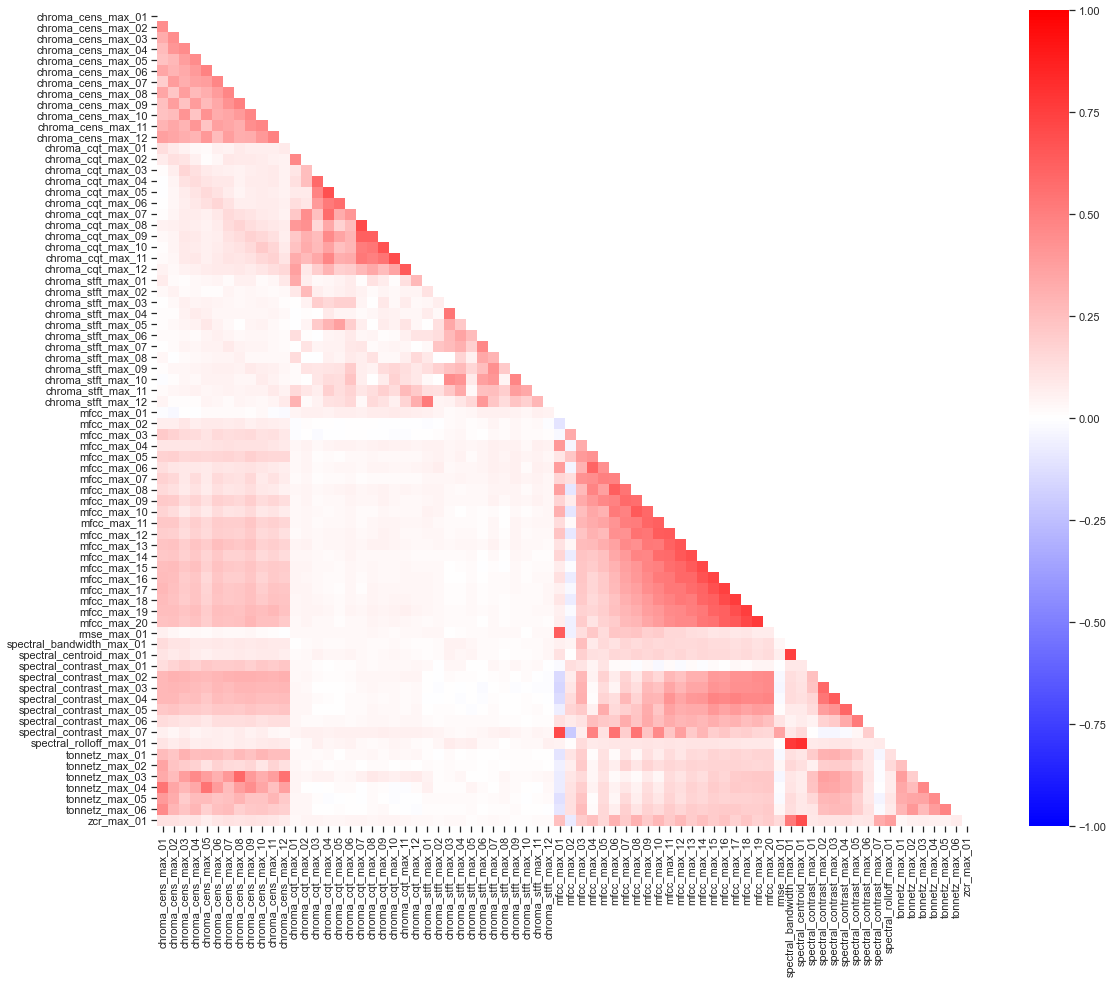

In [16]:
corr = df[fts.max()].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, square=True)
    ax.tick_params(left=True, bottom=True)

fig;

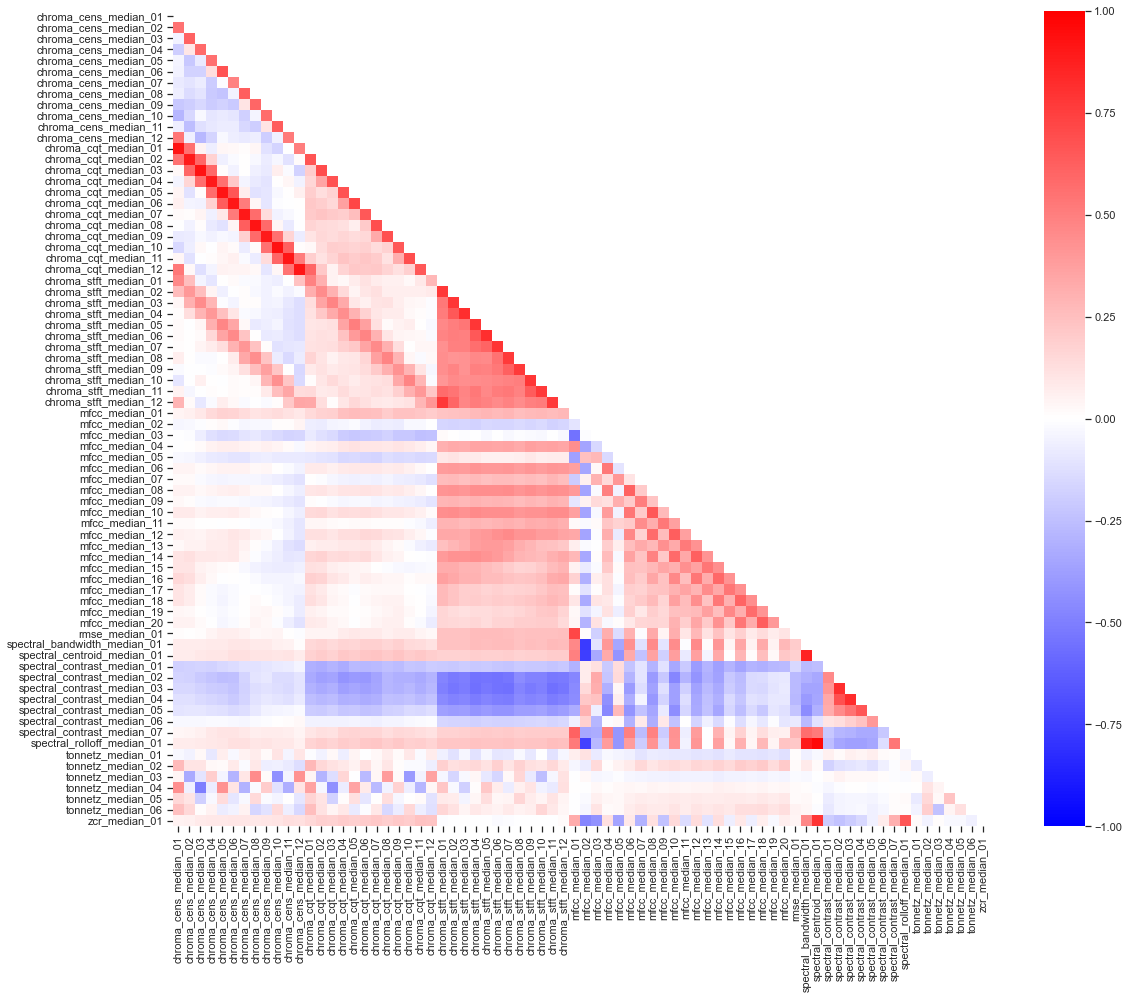

In [17]:
corr = df[fts.median()].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, square=True)
    ax.tick_params(left=True, bottom=True)

fig;

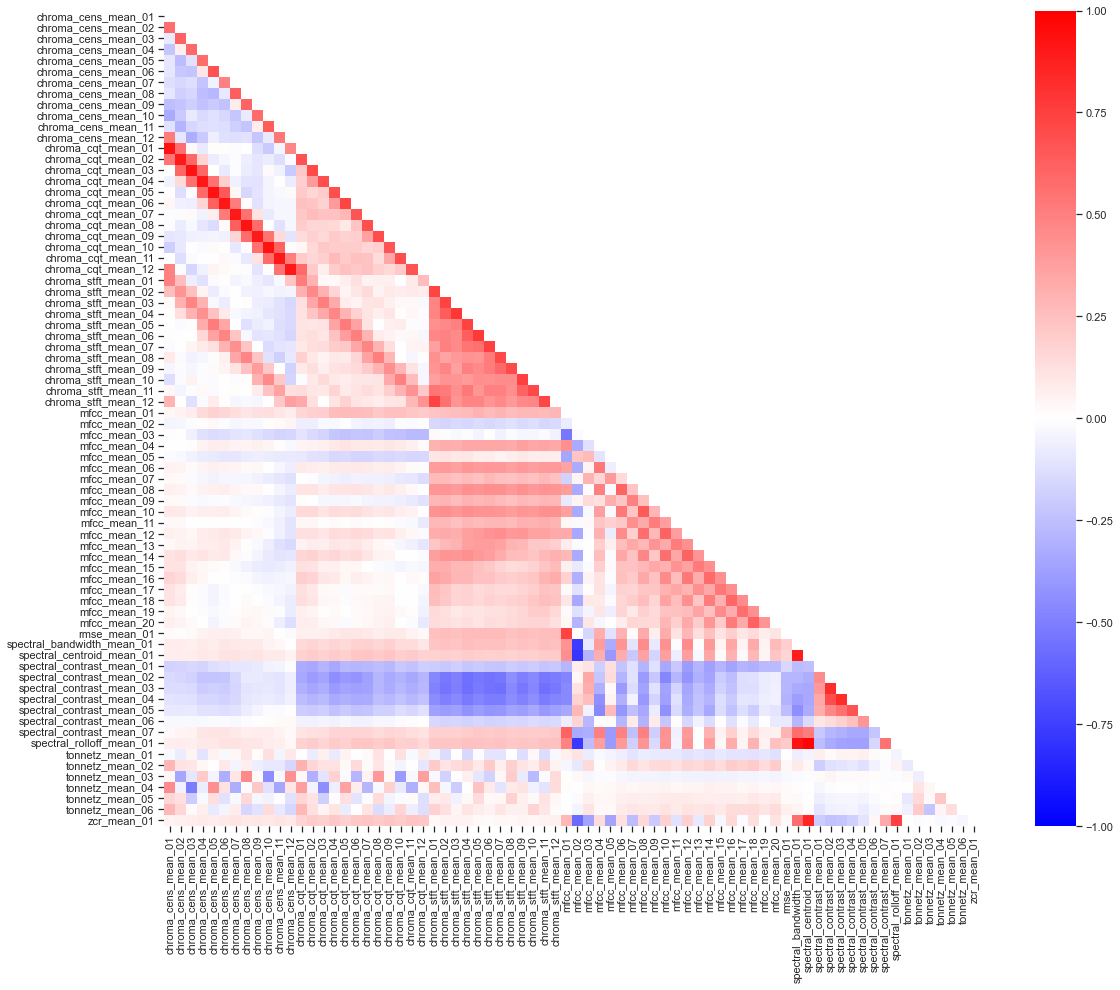

In [18]:
corr = df[fts.mean()].corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap='bwr', xticklabels=True, yticklabels=True, square=True)
    ax.tick_params(left=True, bottom=True)

fig;

### 5. Missing values and duplicated values

In [19]:
total = df.shape[0]

na = df[fts.all()].isna().sum().sum()
print(f'NA values features: {na} of {total}')
na = df.popularity.isna().sum().sum()
print(f'NA values popularity target: {na} of {total}')
na = df.release.isna().sum().sum()
print(f'NA values release target: {na} of {total}')

dup = df[df[fts.all()].duplicated()].shape[0]
print(f'Duplicate features: {dup} of {total}')
dup = df[df.duplicated()].shape[0]
print(f'Duplicates: {dup} of {total}')

NA values features: 0 of 15000
NA values popularity target: 0 of 15000
NA values release target: 5180 of 15000
Duplicate features: 57 of 15000
Duplicates: 0 of 15000
